In [1]:
import pandas as pd
import requests as rq
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import random
import numpy as np
import h5py
import os
from __future__ import print_function

In [2]:
imgDir = "/work/sagarj/Work/BellLabs/streetview/PPImages/"

In [3]:
df = pd.read_csv("../streetview/votes.csv")

In [4]:
df.keys()

Index([u'left_id', u'right_id', u'winner', u'left_lat', u'left_long',
       u'right_lat', u'right_long', u'category'],
      dtype='object')

In [5]:
df.head()

,left_id,right_id,winner,left_lat,left_long,right_lat,right_long,category
0,513d2dbefdc9f03587002515,51413b2ffdc9f049260058ca,left,41.935385,-87.696485,34.047847,-118.236107,wealthy
1,513d7e23fdc9f0358700733a,513d7ac3fdc9f0358700693f,equal,40.744156,-73.935579,-33.526384,-70.591309,depressing
2,50f60c4dbeb2fed91000028d,513cb652fdc9f03587000a1e,right,45.505837,-122.583705,29.752872,-95.298844,depressing
3,513d9ff9fdc9f0358700887c,513cd544fdc9f03587001efc,left,33.747093,-84.289843,-33.930831,18.406321,depressing
4,513f320cfdc9f0358700e030,513cc3acfdc9f035870016c3,left,52.551685,13.416548,29.763818,-95.394621,safety


In [6]:
grouped = df.groupby('category')

In [7]:
categoryPosts = {}
for k in grouped.groups.keys():
    categoryPosts[k] = grouped.get_group(k)

In [8]:
categoryPosts.keys()

['beautiful', 'boring', 'depressing', 'safety', 'lively', 'wealthy']

In [9]:
DimensionDF = categoryPosts['beautiful']

In [10]:
len(DimensionDF)

175361

In [11]:
numbers = DimensionDF.groupby('left_id')

In [12]:
VotesDistribution = numbers.size()

In [13]:
from trueskill import Rating , rate_1vs1 , rate
def trueSkillRate(df):
    skills = {}
    ratingTable = []
    for index, row in df.iterrows():
        if row['left_id'] not in skills:
            skills[row['left_id']] = Rating()
        if row['right_id'] not in skills:
            skills[row['right_id']] = Rating()
            
        if row['winner'] == 'left':
            nRLeft , nRRight = rate_1vs1(skills[row['left_id']] , skills[row['right_id']] )
            skills[row['left_id']] = nRLeft
            skills[row['right_id']] = nRRight
            touple = {row['left_id']:nRLeft , row['right_id'] : nRRight}
            ratingTable.append(touple)
        elif row['winner'] == 'right':
            nRRight , nRLeft = rate_1vs1(skills[row['right_id']] , skills[row['left_id']] )
            skills[row['left_id']] = nRLeft
            skills[row['right_id']] = nRRight
            touple = {row['left_id']:nRLeft , row['right_id'] : nRRight}
            ratingTable.append(touple)
        else:
            nRRight , nRLeft = rate_1vs1(skills[row['right_id']] , skills[row['left_id']] , drawn = True )
            skills[row['left_id']] = nRLeft
            skills[row['right_id']] = nRRight
            touple = {row['left_id']:nRLeft , row['right_id'] : nRRight}
            ratingTable.append(touple)
    
    return skills , ratingTable

In [14]:
def stabilityAnalysis(df , start , end):
    classflips = []
    rootflips = []
    numbers = DimensionDF.groupby('left_id')
    TargetDf = numbers.filter(lambda x: len(x) > start)
    depressingSkills , _ = trueSkillRate(TargetDf)
    root1 = [k for k in depressingSkills if depressingSkills[k].mu > 25]
    root2 = [k for k in depressingSkills if depressingSkills[k].mu < 25]

    for i in range(start,end+1):
        
        TargetDf = numbers.filter(lambda x: len(x) > i)
        depressingSkills , _ = trueSkillRate(TargetDf)
        r1 = [k for k in depressingSkills if depressingSkills[k].mu > 25]
        r2 = [k for k in depressingSkills if depressingSkills[k].mu < 25]
        
        TargetDf = numbers.filter(lambda x: len(x) > i+1) 
        depressingSkills , _ = trueSkillRate(TargetDf)
        class1 = [k for k in depressingSkills if depressingSkills[k].mu > 25]
        class2 = [k for k in depressingSkills if depressingSkills[k].mu < 25]
        
        
        flips_root = len(set(root1).intersection(class2)) + len(set(root2).intersection(class1))
        flips_consecutive = len(set(r1).intersection(class2)) + len(set(r2).intersection(class1))
        print ("Total class flips at threshold level %d from %d : %d , %d from root" %(i,i+1,flips_consecutive , flips_root ))
        rootflips.append(flips_root)
        classflips.append(flips_consecutive)

    return classflips , rootflips
        

In [15]:
rollingFlips, rootFlips  = stabilityAnalysis(DimensionDF, 3 , 11)

Total class flips at threshold level 3 from 4 : 506 , 506 from root
Total class flips at threshold level 4 from 5 : 64 , 208 from root
Total class flips at threshold level 5 from 6 : 4 , 40 from root
Total class flips at threshold level 6 from 7 : 0 , 12 from root
Total class flips at threshold level 7 from 8 : 0 , 8 from root
Total class flips at threshold level 8 from 9 : 0 , 7 from root
Total class flips at threshold level 9 from 10 : 0 , 5 from root
Total class flips at threshold level 10 from 11 : 0 , 5 from root
Total class flips at threshold level 11 from 12 : 0 , 3 from root


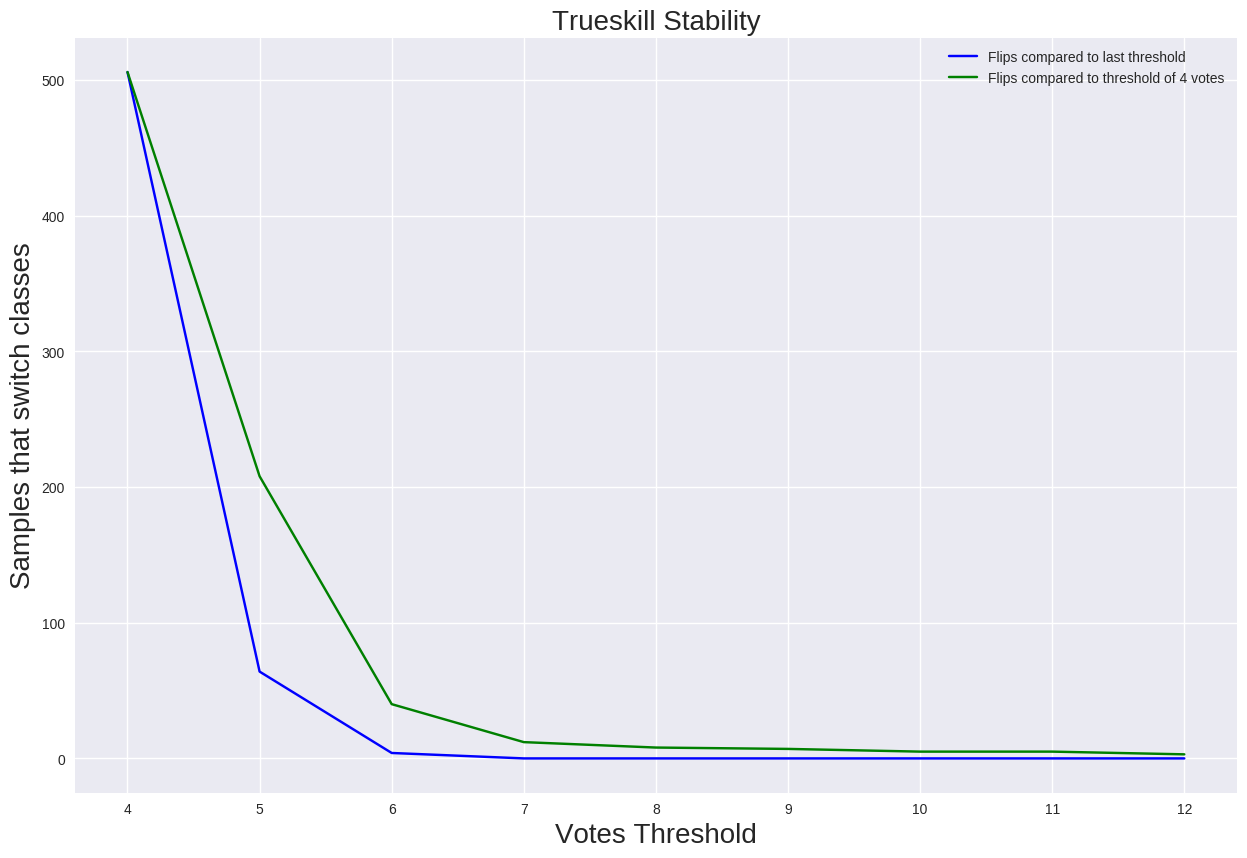

In [16]:
_, ax1 = plt.subplots(figsize=(15, 10))
ax1.plot(range(4,13), rollingFlips  , 'b' )
ax1.plot(range(4,13) , rootFlips  , 'g')

ax1.set_xlabel('Votes Threshold', fontsize = 20)
ax1.set_ylabel('Samples that switch classes' , fontsize = 20)
plt.title("Trueskill Stability" , fontsize = 20)
ax1.legend(["Flips compared to last threshold" , "Flips compared to threshold of 4 votes"])




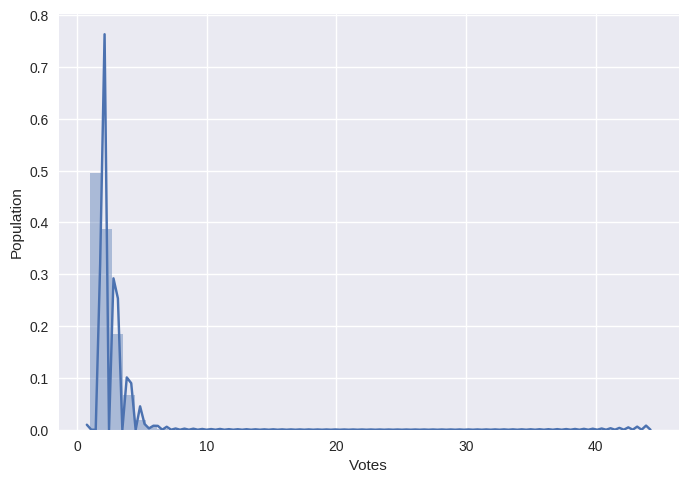

In [17]:
sns.set(rc={"figure.figsize": (16, 12)})
sns.set(font_scale=1)  
ax = sns.distplot(VotesDistribution )
ax.set(xlabel='Votes', ylabel='Population')


In [18]:
TargetDf = numbers.filter(lambda x: len(x) > 3) 

In [19]:
len(TargetDf)

32531

In [20]:
len(TargetDf[(TargetDf['winner'] == 'equal')])

3016

In [21]:
from trueskill import Rating

In [22]:
from trueskill.backends import available_backends
from trueskill import setup
from mpmath import mp
if 'mpmath' in available_backends():
    # mpmath can be used in the current environment
    setup(backend='mpmath')
mp.dps = 32

In [23]:
depressingSkills , depRatingTable = trueSkillRate(TargetDf)

In [24]:
len(list(set(depressingSkills.keys())))

33302

In [25]:
depRatingTable[1]

{'50f4455ffdc9f065f000344c': trueskill.Rating(mu=29.396, sigma=7.171),
 '50f5eab3fdc9f065f0007c7a': trueskill.Rating(mu=20.604, sigma=7.171)}

In [26]:
# rated_depSkills = rate(depRatingTable)

In [27]:
# skill = {}
# for s in rated_depSkills:
#     for k in s:
#         if k in skill:
#             skill[k].append(s[k])
#         else:
#             skill[k] = []
#             skill[k].append(s[k])

In [28]:
#Sorted by plain pairvise matches
sortedImagesSkillsMu = sorted(depressingSkills, key=lambda k: depressingSkills[k].mu)
sortedImagesSkillsSigma = sorted(depressingSkills, key=lambda k: depressingSkills[k].sigma)

In [29]:
#Sorted by ranking tables
# sortedImages =  sorted(skill, key=lambda k: skill[k][-1].mu)

In [30]:
# sortedImagesByVar =  sorted(skill, key=lambda k: skill[k][-1].sigma)

In [31]:
# skill[sortedImages[-1]][0].mu

In [32]:
#Sorted by ranking tables
# imgid = sortedImages[-500]
# Image(imgDir + imgid + ".jpg")

In [33]:
len(sortedImagesSkillsMu)

33302

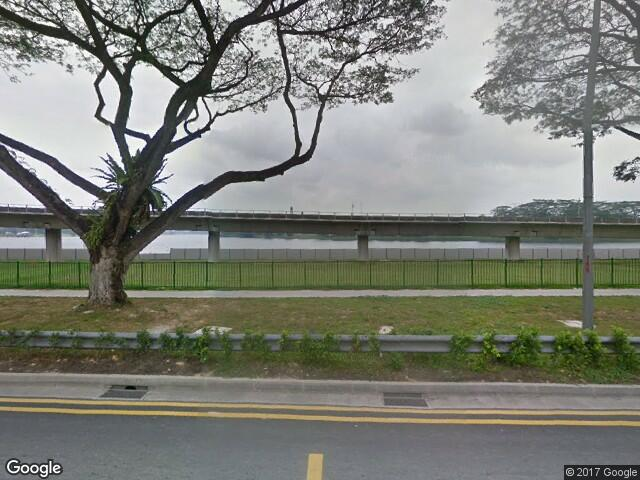

In [34]:
# Sorted by plain pairvise matches
imgid = sortedImagesSkillsMu[-1]
Image(imgDir + imgid + ".jpg")

In [35]:
# dir(rated_depSkills[1][1])

In [36]:
skillMeans = [depressingSkills[k].mu for k in depressingSkills]

In [37]:
maxSkill= np.max(skillMeans)

In [38]:
print (maxSkill)

38.726752364


In [39]:
# means = [skill[k][-1].mu for k in skill]

In [40]:
skillSigmas = [depressingSkills[k].sigma for k in depressingSkills]

In [41]:
# sigmas = [skill[k][-1].sigma for k in skill]

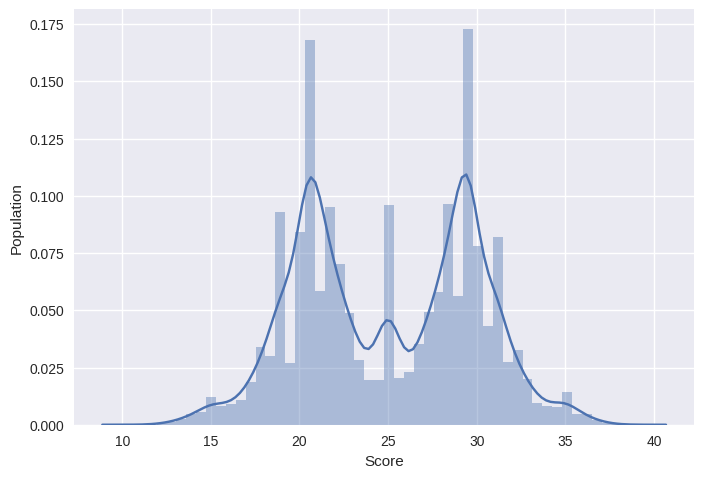

In [42]:
sns.set(rc={"figure.figsize": (16, 12)})
sns.set(font_scale=1) 
# ax = sns.distplot(skillMeans , hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True) )
ax = sns.distplot(skillMeans )
ax.set(xlabel='Score', ylabel='Population')

In [43]:
# sns.distplot(means )

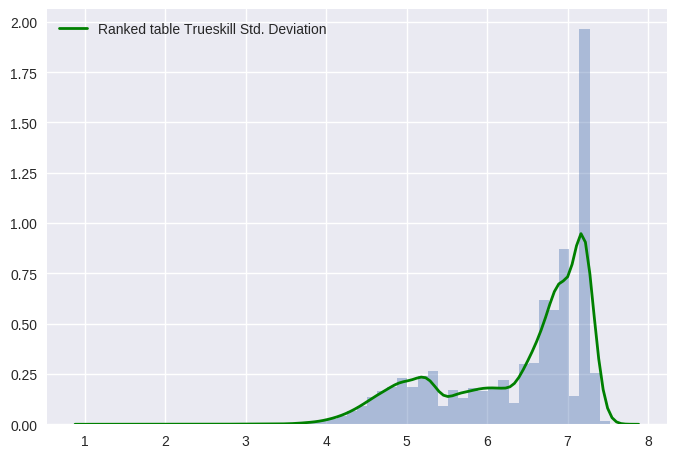

In [44]:
# sns.distplot(sigmas ,kde_kws={"color": "b", "lw": 2, "label": "Paiwise Trueskill Std. Deviation"} )
sns.distplot(skillSigmas , kde_kws={"color": "g", "lw": 2, "label": "Ranked table Trueskill Std. Deviation"},)

In [45]:
Qdf = numbers.filter(lambda x: len(x) > 0) 

In [46]:
def QscoreRating(df):
    W = {}
    L = {}
    win = {}
    loose = {}
    contest = {}
    rating = {}
    for index, row in df.iterrows():
        if row['left_id'] not in contest:
            contest[row['left_id']] = 0
            
            win[row['left_id']] = {}
            win[row['left_id']]['w'] = 0
            win[row['left_id']]['loosers'] = []
            
            loose[row['left_id']] = {}
            loose[row['left_id']]['l'] = 0 
            loose[row['left_id']]['winners'] = []
            
            W[row['left_id']] =0.0
            L[row['left_id']] =0.0
        
        contest[row['left_id']]+=1
        
        if row['winner'] == 'left':
            win[row['left_id']]['w'] += 1
            win[row['left_id']]['loosers'].append(row['right_id'])

        if row['winner'] == 'right':
            loose[row['left_id']]['l'] += 1
            loose[row['left_id']]['winners'].append(row['right_id'])
        
    for k in win:
        W[k] = float(win[k]['w'])/float(contest[k])
        
    for k in loose:
        L[k] = float(loose[k]['l'])/float(contest[k])
    
    for k in contest:
        S1 = sum([W.get(i,0) for i in win[k]['loosers']])
        S2 = sum([L.get(i,0) for i in loose[k]['winners']])
        if S1 == 0:
            S1 = 0.0
        else:
            S1 = float(S1)/float(win[k]['w'])
        
        if S2 == 0:
            S2 = 0.0
        else:
            S2 = float(S2)/float(loose[k]['l'])
        
        r = (10.0/3.0)*(W[k] + S1 - S2 + 1)
        rating[k] = r
    return rating
            

In [47]:
Qscores = QscoreRating(Qdf)

In [48]:
len(set(Qdf['left_id']))

90866

In [49]:
finalQ = {}
for index, row in TargetDf.iterrows():
    finalQ[row['left_id']] = Qscores[row['left_id']]

In [50]:
len(finalQ)

7341

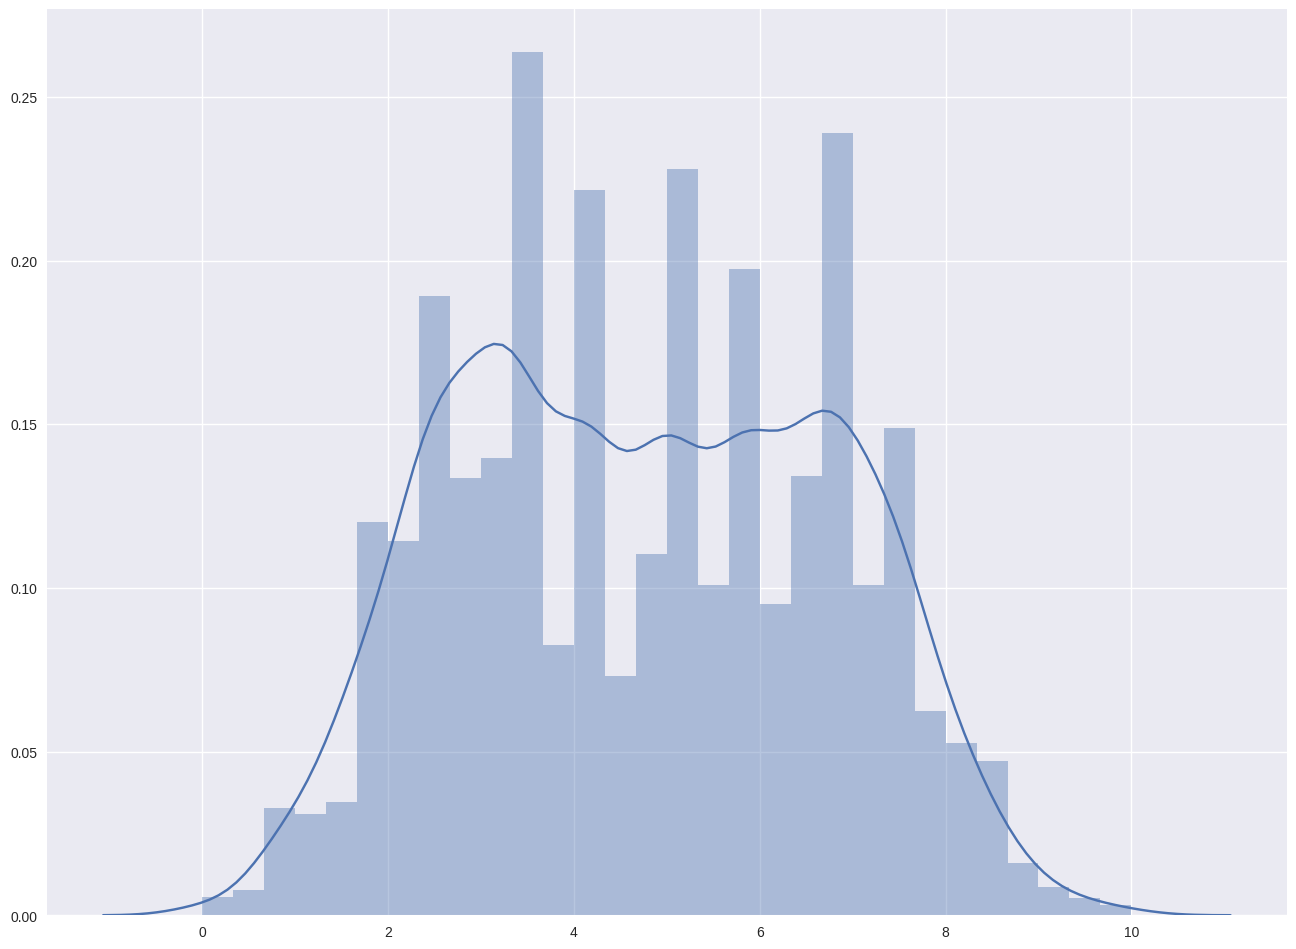

In [56]:
sns.set(rc={"figure.figsize": (16, 12)})
sns.distplot(finalQ.values() )
#sns.distplot(finalQ.values() , hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True) )

In [52]:
sortedSimple =  sorted(finalQ, key=lambda k: finalQ[k])

In [53]:
len(sortedSimple)

7341

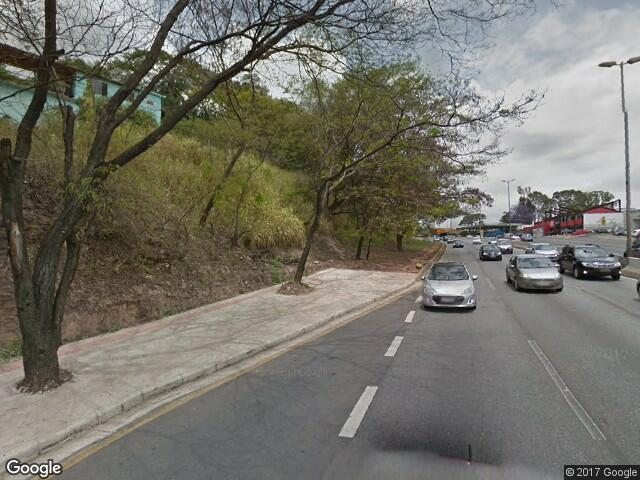

In [68]:
imgid = sortedSimple[3500]
# imgid = "50f43ba4fdc9f065f000326b"
Image(imgDir + imgid + ".jpg")

In [55]:
int(0.2*len(finalQ.keys()))

1468

In [ ]:
import os
import glob
import random
import numpy as np

import cv2
import sys
caffe_root = '/work/sagarj/caffe-rc5/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe.proto import caffe_pb2
import lmdb

#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def make_datum(img, label):
    #image is numpy.ndarray format. BGR instead of RGB
    return caffe_pb2.Datum(
        channels=3,
        width=IMAGE_WIDTH,
        height=IMAGE_HEIGHT,
        label=label,
        data=np.rollaxis(img, 2).tostring())


In [ ]:
testKeys = random.sample(list(finalQ.keys()), int(0.2*len(finalQ.keys())))


In [ ]:
trainKeys = [k for k in finalQ.keys() if k not in testKeys]

In [ ]:
len(set(trainKeys).intersection(testKeys))

In [ ]:
len(testKeys) , len(trainKeys)

In [ ]:
train_data = {}
for k in trainKeys:
    src = imgDir + k + ".jpg"
    if not os.path.exists(src):
        continue
    else:
        train_data[k] = src
        
test_data = {}
for k in testKeys:
    src = imgDir + k + ".jpg"
    if not os.path.exists(src):
        continue
    else:
        test_data[k] = src
    
    

In [ ]:
len(train_data) , len(test_data)

## Create train and test path files for transfer learning

In [ ]:
# ImageList = "../Data/TrainImageListBinary.txt"
# label = 0
# for in_idx, (k, img_path) in enumerate(train_data.items()):
#     val = int(depressingSkills[k].mu)
# #     if val < 23:
# #         label = 0
# #     elif val > 22 and val < 29:
# #         label = 1
# #     elif val > 28:
# #         label = 2
#     if val < 25:
#         label = 0
#     elif val > 25:
#         label = 1
#     with open(ImageList,'a') as f:
#         f.write(img_path + "," + str(label) + "\n")

# ImageList = "../Data/TestImageListBinary.txt"
# label = 0
# for in_idx, (k, img_path) in enumerate(test_data.items()):
#     val = int(depressingSkills[k].mu)
# #     if val < 23:
# #         label = 0
# #     elif val > 22 and val < 29:
# #         label = 1
# #     elif val > 28:
# #         label = 2
#     if val < 25:
#         label = 0
#     elif val > 25:
#         label = 1
#     with open(ImageList,'a') as f:
#         f.write(img_path + "," + str(label) + "\n")
    

## LMDB creation Logic

In [ ]:
train_lmdb = '../Data/train_lmdb_Beauty_MultiClass_Q'
validation_lmdb = '../Data/validation_lmdb_Beauty_MultiClass_Q'
log = "lmdblogs.log"

In [ ]:
# print ('Creating train_lmdb')
# f = open(log,'w')
# in_db = lmdb.open(train_lmdb, map_size=int(1e12))
# with in_db.begin(write=True) as in_txn:
#     for in_idx, (k, img_path) in enumerate(train_data.items()):
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#         val = int(finalQ[k])
#         label = 0
#         if val < 3.5:
#             label = 0
#         elif val >=3.5 and val < 7:
#             label = 1
#         elif val >= 7:
#             label = 2
# #         if val < 25:
# #             label = 0
# #         elif val > 25:
# #             label = 1
        
#         datum = make_datum(img, label)
#         in_txn.put('{:0>5d}'.format(in_idx), datum.SerializeToString())
#         line = '{:0>5d}'.format(in_idx) + ':' + img_path + "\n"
#         f.write(line)
# in_db.close()


# print ('\nCreating validation_lmdb')

# in_db = lmdb.open(validation_lmdb, map_size=int(1e12))
# with in_db.begin(write=True) as in_txn:
#     for in_idx, (k, img_path) in enumerate(test_data.items()):
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#         val = int(depressingSkills[k].mu)
#         label = 0
#         if val < 23:
#             label = 0
#         elif val > 22 and val < 29:
#             label = 1
#         elif val > 28:
#             label = 2
# #         if val < 25:
# #             label = 0
# #         elif val > 25:
# #             label = 1
        
#         datum = make_datum(img, label)
#         in_txn.put('{:0>5d}'.format(in_idx), datum.SerializeToString())
#         line = '{:0>5d}'.format(in_idx) + ':' + img_path + "\n"
#         f.write(line)
# in_db.close()
# f.close()
# print ('\nFinished processing all images')


## HD5 creation logic

In [ ]:
# Extract mean from the mean image file
# mean_file_binaryproto = '../Data/Safety8Mean.binaryproto' # Mean image file
# mean_blobproto_new = caffe.proto.caffe_pb2.BlobProto()
# f = open(mean_file_binaryproto, 'rb')
# mean_blobproto_new.ParseFromString(f.read())
# mean_image = caffe.io.blobproto_to_array(mean_blobproto_new)
# f.close()

In [ ]:
# dataset_test = []
# labels = []
# BatchSize = 5000

# for in_idx, (k, img_path) in enumerate(test_data.items()):
#     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#     img = np.rollaxis(img, 2) - mean_image
#     dataset_test.append(img)
#     labels.append(float(depressingSkills[k].mu / maxSkill))

    
# dataset_t = np.stack(dataset_test,axis = 0)
# dataset_t = np.squeeze(dataset_t, axis=1)
# labels = np.asarray(labels)

# i = 0
# DIR = "/work/sagarj/Work/BellLabs/Data/h5Data/"

# text_fn = os.path.join(DIR, 'test_SafetyRegression.txt')
# for start, end in zip(range(0, len(dataset_t), BatchSize), range(BatchSize, len(dataset_t), BatchSize)):
    
#     h5_fn = DIR+'test_SafetyRegression' + str(i) +'.h5'
#     with h5py.File(h5_fn, 'w') as f:
#         f['data'] = dataset_t[start:end]
#         f['label'] = labels[start:end]
        
#     with open(text_fn, 'a') as f:
#         print(h5_fn, file = f)
#     i+=1


In [ ]:
# dataset_t.shape , labels.shape

In [ ]:
# dataset_test = []
# labels = []
# BatchSize = 5000


# for in_idx, (k, img_path) in enumerate(train_data.items()):
#     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#     img = np.rollaxis(img, 2) - mean_image
#     dataset_test.append(img)
#     labels.append(float(depressingSkills[k].mu / maxSkill))


# dataset_t = np.stack(dataset_test,axis = 0)
# dataset_t = np.squeeze(dataset_t, axis=1)
# labels = np.asarray(labels)
# i = 0
# DIR = "/work/sagarj/Work/BellLabs/Data/h5Data/"
# text_fn = os.path.join(DIR, 'train_SafetyRegression.txt')
# for start, end in zip(range(0, len(dataset_t), BatchSize), range(BatchSize, len(dataset_t), BatchSize)):
    
#     h5_fn = DIR+'train_SafetyRegression' + str(i) +'.h5'
#     with h5py.File(h5_fn, 'w') as f:
#         f['data'] = dataset_t[start:end]
#         f['label'] = labels[start:end]
        
#     with open(text_fn, 'a') as f:
#         print(h5_fn, file = f)
#     i+=1


In [ ]:
# dataset_t.shape , labels.shape

In [ ]:
# sns.distplot(labels )

## Moving Logic for moving images

In [ ]:
# curatedDir = "../streetview/RankedDepress_4/"
# beauty = "1/"
# notBeauty = "0/"
# train = curatedDir + "train/"
# test = curatedDir + "test/"

In [ ]:
# from shutil import copyfile


In [ ]:
#Move Train SEtL 

# for k in trainKeys:
#     src = imgDir + k + ".jpg"
#     if not os.path.exists(src):
#         continue
#     if depressingSkills[k].mu > 25:
#         destDir = curatedDir + train + beauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir+ k + ".jpg"
#         copyfile(src , dest)
    
#     if depressingSkills[k].mu < 25:
#         destDir = curatedDir + train + notBeauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir + k + ".jpg"
#         copyfile(src , dest)    

In [ ]:
# Move test

# for k in keys:
#     src = imgDir + k + ".jpg"
#     if not os.path.exists(src):
#         continue
#     if depressingSkills[k].mu > 25:
#         destDir = curatedDir + test + beauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir+ k + ".jpg"
#         copyfile(src , dest)
    
#     if depressingSkills[k].mu < 25:
#         destDir = curatedDir + test + notBeauty 
#         if not os.path.exists(os.path.dirname(destDir)):
#             os.makedirs(os.path.dirname(destDir))
#         dest = destDir + k + ".jpg"
#         copyfile(src , dest)    

## Test Network and correlations

In [ ]:
import sys
import lmdb
import h5py
caffe_root = '/work/sagarj/caffe-rc5/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
from collections import defaultdict
import caffe


In [ ]:
model_root = "/work/sagarj/Work/BellLabs/caffe_models/places/"
model_state = "places_beauty_Qscore_iter_9463.caffemodel"
model_deplot = "places205CNN_deploy_upgraded.prototxt"

test_lmdb_path = '../Data/validation_lmdb_Beauty_MultiClass_Q' # Test LMDB database path
mean_file_binaryproto = '../Data/multiclassBig.binaryproto.binaryproto' # Mean image file


In [ ]:
caffe.set_mode_gpu()

In [ ]:
model_def = model_root+model_deplot
model_weights = model_root + model_state

In [ ]:
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)


In [ ]:
net.layer_dict

In [ ]:
# np.asarray(net.blobs['fc8'].data)

In [ ]:
# f = h5py.File('../Data/h5Data/test_SafetyRegression0.h5','r')

# data = f['data']
# labels = f['label']


In [ ]:
# out = net.forward_all(data=np.asarray(data))

In [ ]:
# Extract mean from the mean image file
mean_blobproto_new = caffe.proto.caffe_pb2.BlobProto()
f = open(mean_file_binaryproto, 'rb')
mean_blobproto_new.ParseFromString(f.read())
mean_image = caffe.io.blobproto_to_array(mean_blobproto_new)
f.close()

In [ ]:
count = 0
correct = 0
labels = [] # (real,pred) -> int
preds = []
# labels_set = set()

lmdb_env = lmdb.open(test_lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()

for key, value in lmdb_cursor:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(value)
    label = datum.label
    labels.append(label)
    image = caffe.io.datum_to_array(datum)
    image = image.astype(np.uint8)
    out = net.forward_all(data=np.asarray([image]) - mean_image)

    plabel = out['fc8'][0][0]
    preds.append(plabel)
    count += 1

In [ ]:
out.keys()

In [ ]:
preds = [out['fc8'][i][0] for i in range(len(out['fc8']))]

In [ ]:
labels[0]

In [ ]:
sns.set(rc={"figure.figsize": (16, 12)})
sns.set(font_scale=1) 
ax1 = sns.distplot(labels )
ax2 = sns.distplot(preds )
# ax.set(xlabel='Score', ylabel='Population')

In [ ]:
# g = sns.regplot(np.asarray(labels) ,np.asarray(preds))
g = sns.jointplot(np.asarray(labels), np.asarray(preds), kind="reg")

sns.despine()

In [ ]:
del net